In [1]:
%cd ../
%matplotlib inline

/home/eli/AnacondaProjects/HTFATorch


In [2]:
# import dependencies
import logging
import htfa_torch.tfa as TFA
import htfa_torch.utils as utils

In [3]:
tfa = TFA.TopographicalFactorAnalysis('data/s0.mat', num_factors=10)
losses = tfa.train(num_steps=15, log_level=logging.INFO)

03/01/2018 17:28:37 [Epoch 1] (152ms) Posterior free-energy 2.20523187e+09
03/01/2018 17:28:37 [Epoch 2] (95ms) Posterior free-energy 1.48103590e+09
03/01/2018 17:28:37 [Epoch 3] (64ms) Posterior free-energy 8.93687104e+08
03/01/2018 17:28:38 [Epoch 4] (89ms) Posterior free-energy 6.22617024e+08
03/01/2018 17:28:38 [Epoch 5] (91ms) Posterior free-energy 4.76005056e+08
03/01/2018 17:28:38 [Epoch 6] (84ms) Posterior free-energy 4.05875360e+08
03/01/2018 17:28:38 [Epoch 7] (88ms) Posterior free-energy 3.70420064e+08
03/01/2018 17:28:38 [Epoch 8] (91ms) Posterior free-energy 3.52589184e+08
03/01/2018 17:28:38 [Epoch 9] (85ms) Posterior free-energy 3.48088768e+08
03/01/2018 17:28:38 [Epoch 10] (87ms) Posterior free-energy 3.47956352e+08
03/01/2018 17:28:38 [Epoch 11] (87ms) Posterior free-energy 3.44606624e+08
03/01/2018 17:28:38 [Epoch 12] (90ms) Posterior free-energy 3.45695840e+08
03/01/2018 17:28:38 [Epoch 13] (84ms) Posterior free-energy 3.40225664e+08
03/01/2018 17:28:38 [Epoch 14] (8

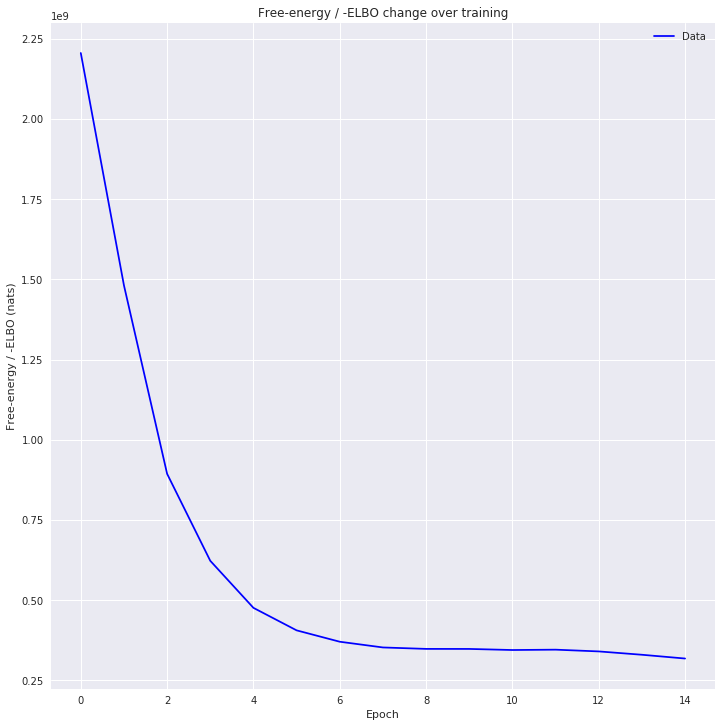

03/01/2018 17:28:41 Mean Factor Centers: [[  8.115596  -52.508957   18.753578 ]
 [ -4.277821  -53.25363    50.985584 ]
 [  1.9589986 -55.795376   41.188915 ]
 [ -7.165922  -46.49791    34.097134 ]
 [  5.741248  -44.447735   29.63536  ]
 [  6.1764007 -50.543774   51.485153 ]
 [  8.401304  -59.584896   30.956047 ]
 [ -4.5595183 -64.63203    30.903275 ]
 [ -4.0359516 -53.19099    19.78117  ]
 [  3.2766914 -67.740456   45.664536 ]]
03/01/2018 17:28:41 Mean Factor Log Widths: [4.738221  5.0262394 5.0933475 4.8045373 4.971011  5.092792  4.845896
 4.974143  4.587607  5.147699 ]
03/01/2018 17:28:41 Mean Weights: [[-0.5160509   5.363389   -5.4377403  ...  2.3910027   1.7682598
   4.563755  ]
 [-1.5015664   3.08011    -1.5066017  ...  1.0356834   1.2704115
   2.559603  ]
 [-1.3724673   1.1391459  -0.56629264 ...  0.3622235  -0.8565902
   0.8749114 ]
 ...
 [-1.1542847   0.7736489  -1.593417   ... -0.56286657 -0.00570365
   0.1284888 ]
 [-0.7227478   0.7145823  -2.1416173  ...  0.17290443 -0.17571

In [4]:
utils.plot_losses(losses)

means = tfa.mean_parameters(log_level=logging.INFO)

results = tfa.results()
logging.info(results)

In [5]:
import hypertools as hyp
import numpy as np
import seaborn as sns

import nilearn.plotting as niplot

from nilearn.input_data import NiftiMasker
import nibabel as nib
import scipy.spatial.distance as sd

from IPython.display import YouTubeVideo, HTML

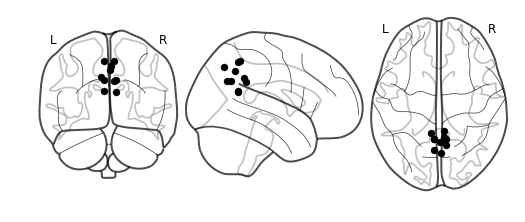

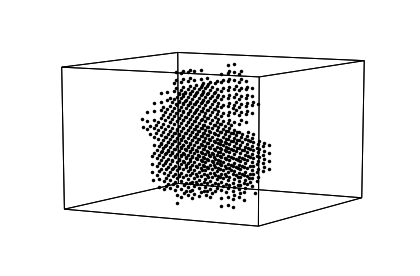

In [6]:
niplot.plot_connectome(np.eye(tfa.num_factors), means['mean_factor_center'], node_color='k')
hyp.plot(tfa.voxel_locations.numpy(), 'k.')